<a href="https://colab.research.google.com/github/Siu0901/AI_study/blob/main/ResNet_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, random_split

In [2]:
transform = transforms.Compose([
    # 데이터셋 중간에 흑백 껴있어 채널 3으로 바꿔주는 코드
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [3]:
full_dataset = torchvision.datasets.Caltech256(root='./data', download=True, transform=transform)

100%|██████████| 1.18G/1.18G [00:23<00:00, 50.3MB/s]


In [4]:
# 데이터 8:2로 나누기
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [5]:
batch_size = 32
train_loarder = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()
    self.stride = stride
    self.input = in_channels
    self.output = out_channels

    self.block = nn.Sequential(
        nn.Conv2d(self.input, self.output, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(self.output),
        nn.ReLU(),
        nn.Conv2d(self.output, self.output, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(self.output),
    )
    # 나중에 더할 때 크기 안 맞을 수 있으니 사이즈 조절
    if self.stride != 1 or self.input != self.output:
        self.downsample = nn.Sequential(
            nn.Conv2d(self.input, self.output, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.output)
        )

  def forward(self, x):
    out = self.block(x)

    if self.stride != 1 or self.input != self.output:
      x = self.downsample(x)

    out = F.relu(out + x)
    return out

In [29]:
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=257):
    super(ResNet, self).__init__()
    self.base = nn.Sequential(
        nn.Conv2d(3,64, kernel_size=7, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    self.in_channels = 64

    self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512, num_classes)

  def make_layer(self, block, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []

    for stride in strides:
      layers.append(block(self.in_channels, out_channels, stride))
      self.in_channels = out_channels

    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.base(x)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.avgpool(out)
    out = out.view(out.size(0), -1) # Flatten이랑
    out = self.fc(out)
    return out

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
model = ResNet(ResidualBlock, [2,2,2,2]).to(device)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [37]:
from IPython.testing import test
num_epochs = 15
# 학습 코드 (여긴 무슨 모델이든 다 거의 똑같음)
for epoch in range(num_epochs):
  model.train()
  running_train_loss = 0.0

  for i, (images, labels) in enumerate(train_loarder):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    running_train_loss += loss.item()

    if (i+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loarder)}], Train Loss: {running_train_loss/100:.4f}')
        running_train_loss = 0.0

  # 테스트 데이터 손실과 정확도 파악 (학습에 영향 X)
  model.eval()
  t_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for t_images, t_labels in test_loader:
      t_images = t_images.to(device)
      t_labels = t_labels.to(device)

      t_output = model(t_images)
      t_batch_loss = criterion(t_output, t_labels)
      t_loss += t_batch_loss.item()

      _, t_predicted = torch.max(t_output.data, 1)
      total += t_labels.size(0)
      correct += (t_predicted == t_labels).sum().item()

  avg_test_loss = t_loss / len(test_loader)
  test_accuracy = 100 * correct / total
  print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
  print('-' * 60)

Epoch [1/15], Step [100/766], Train Loss: 4.3814
Epoch [1/15], Step [200/766], Train Loss: 4.3252
Epoch [1/15], Step [300/766], Train Loss: 4.3445
Epoch [1/15], Step [400/766], Train Loss: 4.3356
Epoch [1/15], Step [500/766], Train Loss: 4.3355
Epoch [1/15], Step [600/766], Train Loss: 4.2267
Epoch [1/15], Step [700/766], Train Loss: 4.2291
Epoch [1/15], Test Loss: 4.1810, Test Accuracy: 17.05%
------------------------------------------------------------
Epoch [2/15], Step [100/766], Train Loss: 4.1212
Epoch [2/15], Step [200/766], Train Loss: 4.0951
Epoch [2/15], Step [300/766], Train Loss: 4.0017
Epoch [2/15], Step [400/766], Train Loss: 4.0376
Epoch [2/15], Step [500/766], Train Loss: 4.0932
Epoch [2/15], Step [600/766], Train Loss: 3.9732
Epoch [2/15], Step [700/766], Train Loss: 3.9902
Epoch [2/15], Test Loss: 3.9723, Test Accuracy: 19.75%
------------------------------------------------------------
Epoch [3/15], Step [100/766], Train Loss: 3.8363
Epoch [3/15], Step [200/766], Tra

In [38]:
model.eval() # 평가모드로 전환
with torch.no_grad(): # 기울기 계산 비활성화 하는거
  correct = 0
  total = 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print(f"테스트 데이터셋 정확도: {100 * correct / total}%")

테스트 데이터셋 정확도: 36.76902972884678%


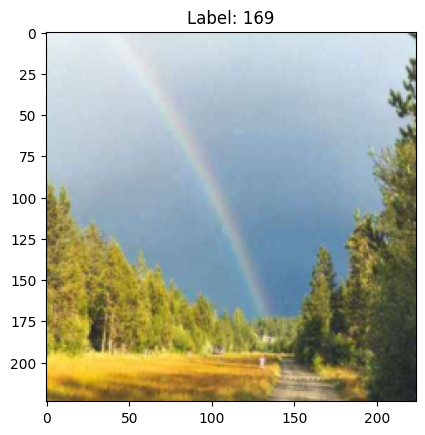

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def show(idx):
  img_tensor = train_dataset[idx][0]
  nimg = img_tensor * 0.5 + 0.5  # unnormalize
  nimg = nimg.numpy().transpose(1, 2, 0)

  plt.title(f'Label: {train_dataset[idx][1]}')
  plt.imshow(nimg)
  plt.show()

show(30)